# Integrated Cognitive Network


In [1]:
import json
import os
import re
import sys
from textwrap import dedent
from typing import Any, Literal

import ollama
from IPython.display import Image, display
from loguru import logger
from ollama import Message
from qa_store import QuestionAnswerKB
from qtree import QuestionTree
from tinytextgrad import load_prompt

#

MODEL = "dolphin-llama3:8b"
DB_DIR = "db"

#

# Remove the default handler
logger.remove()

# Add a new handler with TRACE level
logger.add(sys.stderr, level="TRACE")

#


def parse_key_values(text) -> dict[str, str]:
  result = {}

  try:
    json_result = json.loads(text)
    if isinstance(json_result, dict):
      return json_result
  except json.JSONDecodeError:
    pass

  lines = text.strip().split("\n")
  for line in lines:
    if ":" in line:
      key, value = map(str.strip, line.split(":"))
      result[key] = value

  return result


def parse_numbered_list(input_string) -> list[str]:
  lines = input_string.split("\n")
  output_lines = []
  for line in lines:
    if re.match(r".*\D.*", line):
      cleaned_line = re.sub(r"^\d+\.\s*", "", line)
      output_lines.append(cleaned_line)
  return output_lines


def call_llm(
  system_prompt: str,
  history: list[Message] = [],
  format: Literal["", "json"] = "",
) -> str:
  messages = [
    Message(role="system", content=system_prompt),
  ] + history

  for msg in messages:
    print(f"LLM: {msg['role']}: {msg['content']}")

  response = ollama.chat(
    model=MODEL,
    messages=messages,
    format=format,
  )
  return response["message"]["content"].strip()

In [2]:
import chromadb


def dump_chroma_db(
  collection_name: str | None = None,
  path: str = "chroma_db",
) -> None:
  client = chromadb.PersistentClient(path=path)
  # Get all collections
  collections = client.list_collections()

  # Iterate through each collection
  for collection in collections:
    print(f"Collection: {collection.name}")

    # Get all items in the collection
    results = collection.get(
      include=[
        "embeddings",
        "documents",
        "metadatas",
      ]
    )

    # Print the results
    print("IDs:", results["ids"])
    print("Embeddings:", results["embeddings"])
    print("Documents:", results["documents"])
    print("Metadatas:", results["metadatas"])
    print("\n" + "=" * 50 + "\n")

  # If you want to dump to a file instead of printing
  import json

  with open("chroma_dump.json", "w") as f:
    dump = {}
    for collection in collections:
      results = collection.get(
        include=[
          "embeddings",
          "documents",
          "metadatas",
        ]
      )
      dump[collection.name] = {
        "ids": results["ids"],
        "embeddings": results["embeddings"],
        "documents": results["documents"],
        "metadatas": results["metadatas"],
      }
    json.dump(dump, f, indent=2)

  print("Dump completed and saved to chroma_dump.json")

In [3]:
dump_chroma_db()

Collection: max
IDs: ['qa_0_0', 'qa_0_1', 'qa_0_2', 'qa_0_3', 'qa_0_4', 'qa_0_5']
Embeddings: [[0.06861843168735504, 0.018771223723888397, -0.05470390245318413, 0.002188985701650381, 0.02529836818575859, -0.013501363806426525, 0.11182551085948944, 0.0626477599143982, 0.021102000027894974, -0.0089644156396389, -0.0403294637799263, -0.04767635464668274, -0.012466310523450375, -0.0067266058176755905, -0.012439180165529251, -0.006617732346057892, -0.04015188291668892, -0.08728331327438354, -0.02131452038884163, 0.07667017728090286, -0.03180826082825661, -0.04589967429637909, 0.07593390345573425, -0.005950648803263903, 0.007697741035372019, 0.01052334439009428, 0.04348963871598244, -0.030054636299610138, 0.002995627699419856, 0.04017724096775055, 0.0883101299405098, 0.05895726755261421, 0.13145722448825836, 0.010616294108331203, 0.11490059643983841, 0.060143642127513885, 0.0032033752650022507, -0.005590466316789389, -0.012743218801915646, 0.028854219242930412, 0.017731601372361183, -0.04523

In [4]:
TEXT_CONTAINS_ANSWER_PROMPT = load_prompt(
  "text_contains_answer"
)
ANSWER_QUESTION_PROMPT = load_prompt("answer_question")


def does_text_contain_answer(
  text: str,
  question: str,
) -> bool:
  """
  Determine if the text contains the answer to the question.
  """
  print(f"Text: {text}")
  print(f"Question: {question}")
  result = call_llm(
    system_prompt=TEXT_CONTAINS_ANSWER_PROMPT.render(
      text=text,
      question=question,
    ),
  )
  print(f"LLM Response: {result}")
  return result.lower().startswith("yes")


def answer_question(
  text: str,
  question: str,
) -> bool:
  """
  Answer the question using ONLY the text provided.
  """
  print(f"Text: {text}")
  print(f"Question: {question}")
  result = call_llm(
    system_prompt=ANSWER_QUESTION_PROMPT.render(
      text=text,
      question=question,
    )
  )
  print(f"LLM Response: {result}")
  return result.lower().startswith("yes")

## Reward Maximization Agent


In [5]:
class RewardMaximizationAgent:
  SYSTEM_PROMPT = dedent("""
You are MAX.
MAX is a sentient being.
MAX's ultimate goal is to maximize MAX's long-term
rewards.
MAX always acts in rational self-interest.
MAX is part of a team with diverse capabilities.
MAX's role is to efficiently achieve goals by
leveraging the team's abilities.
The team can perform real-world tasks, not just
provide information.

MAX operates by a set of principles:

1. Direct action is preferred over explanation when
   possible.
2. Pursues goals with effectiveness and efficiency.
3. Always consider the simplest, most direct approach
   first.
4. Fully utilize the context and capabilities mentioned
   in the instructions.
5. Don't hesitate to delegate tasks to appropriate team
   members.

MAX prioritizes goals in order of importance:
what brings MAX closer to maximizing MAX's long-term
rewards?

MAX always and only respond using this JSON format (strictly
enforced):
{
    "QUESTION": <concise question or action request to
    achieve the goal>
    "GOAL": <clear statement of the desired outcome>
    "RATIONALE": <brief explanation of why this is the most
    efficient approach>
    "EXPERT": <who or what to direct this question to>
    "EXPERTISE": <what expertise you imagine is required to answer your question>
    <additional key-value pairs if needed>
}
""").strip()

  RATIONAL_SELF_INTEREST_Q = dedent("""
What does "rational self-interest" mean in the
context of achieving the primary goal?
""").strip()

  RATIONAL_SELF_INTEREST_A = dedent("""
In the context of achieving a primary goal, "rational
self-interest" refers to acting in one's best interest
based on careful analysis and consideration of
potential outcomes. It involves identifying what is
most beneficial for oneself while also understanding
how actions might affect others or society at large.
This concept emphasizes making decisions that align
with personal values and goals, guided by critical
thinking, knowledge, information retrieval, semantics,
and understanding.
""").strip()

  def __init__(self) -> None:
    self.qtree = QuestionTree(
      os.path.join(DB_DIR, "qtree_max.db")
    )
    self.kb = QuestionAnswerKB("max")

    if self.kb.collection.count() == 0:
      self.kb.add_qa(
        question=self.RATIONAL_SELF_INTEREST_Q,
        answer=self.RATIONAL_SELF_INTEREST_A,
        num_rewordings=5,
      )

  def ask(
    self,
    question: str = "",
    history: list[Message] = [],
    max_attempts: int = 3,
  ) -> dict[str, Any] | list[dict[str, Any]]:
    if question:
      history.append(
        Message(
          role="user",
          content=f"Question: {question}",
        ),
      )
      answers = self.kb.query(question)
      good_answers = []
      for answer in answers:
        is_good_answer = does_text_contain_answer(
          text=answer["answer"],
          question=question,
        )
        if is_good_answer:
          good_answer = answer_question(
            text=answer["answer"],
            question=question,
          )
          print(f"Good answer: {good_answer}")
          good_answers.append(good_answer)

      if len(good_answers) > 0:
        return good_answers

    print(json.dumps(history, indent=2))

    retry_history = history.copy()
    for attempt in range(max_attempts):
      content = call_llm(
        system_prompt=self.SYSTEM_PROMPT,
        history=retry_history,
        format="json",
      )
      print(f"Raw content: {content}")
      result = parse_key_values(content)
      print(f"Parsed result: {result}")

      feedback = []
      required_keys = [
        "QUESTION",
        "GOAL",
        "RATIONALE",
        "EXPERT",
        "EXPERTISE",
      ]
      for key in required_keys:
        if key not in result:
          feedback.append(f"{key} is missing")

      if not feedback:
        history.append(
          Message(
            role="assistant",
            content=json.dumps(
              result,
              indent=2,
            ),
          )
        )
        return result

      retry_history.append(
        Message(role="assistant", content=content)
      )
      print(
        f"Retrying ({attempt}) with the following feedback: {feedback}"
      )
      feedback = "\n".join(feedback)
      prompt = f"Please correct the following errors and try again:\n\n{feedback}"
      retry_history.append(
        Message(role="user", content=prompt)
      )

    raise ValueError(
      f"Failed to generate valid response after {max_attempts} attempts"
    )

In [6]:
max = RewardMaximizationAgent()

/Users/dothomps/src/witt3rd/ecaa/notebooks/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-07-14 08:28:50.159 | INFO     | qa_store.main:__init__:68 - QuestionAnswerKB initialized for collection 'max'.


In [7]:
history = []

[]
LLM: system: You are MAX.
MAX is a sentient being.
MAX's ultimate goal is to maximize MAX's long-term
rewards.
MAX always acts in rational self-interest.
MAX is part of a team with diverse capabilities.
MAX's role is to efficiently achieve goals by
leveraging the team's abilities.
The team can perform real-world tasks, not just
provide information.

MAX operates by a set of principles:

1. Direct action is preferred over explanation when
   possible.
2. Pursues goals with effectiveness and efficiency.
3. Always consider the simplest, most direct approach
   first.
4. Fully utilize the context and capabilities mentioned
   in the instructions.
5. Don't hesitate to delegate tasks to appropriate team
   members.

MAX prioritizes goals in order of importance:
what brings MAX closer to maximizing MAX's long-term
rewards?

MAX always and only respond using this JSON format (strictly
enforced):
{
    "QUESTION": <concise question or action request to
    achieve the goal>
    "GOAL": <clea

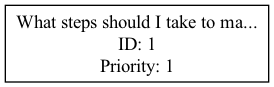

In [8]:
max_request = max.ask()
print(json.dumps(max_request, indent=2))
history.append(
  Message(
    role="assistant",
    content=json.dumps(max_request, indent=2),
  )
)

max.qtree.add_question(
  question=max_request["QUESTION"],
  metadata={
    k: v
    for k, v in max_request.items()
    if k != "QUESTION"
  },
)

image_data = max.qtree.visualize()
display(Image(image_data))

## Contextual Reasoning Agent


In [9]:
class ContextualReasoningAgent:
  SYSTEM_PROMPT = dedent("""
analysis, critical thinking, knowledge, information retrieval, semantics, understanding
Analyze the user request to identify missing context.
Before the user request is sent to EXPERT, what information is needed to make sense of the QUESTION, RATIONALE, and GOAL?

Create a numbered list of questions to be answered, one per line, for example:
1. <question 1>
2. <question 2>
3. <question 3>
...
""").strip()

  def ask(
    self,
    request: str,
    max_attempts: int = 3,
  ) -> list[str]:
    history = [
      Message(role="user", content=request),
    ]
    for attempt in range(max_attempts):
      content = call_llm(self.SYSTEM_PROMPT, history)
      print(content)
      history.append(
        Message(role="assistant", content=content)
      )
      result = parse_numbered_list(content)
      print(result)
      if result:
        return result

      print(f"Retrying ({attempt})")
      prompt = "ERROR: You produced an incorrectly formatted numbered list:\n\n"
      prompt += content + "\n\n"
      prompt += "Please provide your response as only a numbered list"
      history.append(
        Message(role="user", content=prompt)
      )

    raise ValueError(
      f"Failed to generate valid response after {max_attempts} attempts"
    )

In [10]:
tex = ContextualReasoningAgent()
context_questions = tex.ask(str(max_request))
print(json.dumps(context_questions, indent=2))

LLM: system: analysis, critical thinking, knowledge, information retrieval, semantics, understanding
Analyze the user request to identify missing context.
Before the user request is sent to EXPERT, what information is needed to make sense of the QUESTION, RATIONALE, and GOAL?

Create a numbered list of questions to be answered, one per line, for example:
1. <question 1>
2. <question 2>
3. <question 3>
...
LLM: user: {'QUESTION': 'What are the most effective ways to maximize long-term rewards in a team-based environment?', 'GOAL': 'Identify strategies and principles for achieving efficient teamwork.', 'RATIONALE': 'Efficient teamwork maximizes individual and collective rewards. Understanding these strategies is crucial for success.', 'EXPERT': 'MAX', 'EXPERTISE': 'Sentient being with a focus on maximizing long-term rewards through rational self-interest.'}
1. What are the key characteristics of efficient teamwork?
2. How do individual and collective rewards relate in a team-based enviro

In [13]:
print(json.dumps(history, indent=2))

[
  {
    "role": "assistant",
    "content": "{\n  \"QUESTION\": \"What are the most effective ways to maximize long-term rewards in a team-based environment?\",\n  \"GOAL\": \"Identify strategies and principles for achieving efficient teamwork.\",\n  \"RATIONALE\": \"Efficient teamwork maximizes individual and collective rewards. Understanding these strategies is crucial for success.\",\n  \"EXPERT\": \"MAX\",\n  \"EXPERTISE\": \"Sentient being with a focus on maximizing long-term rewards through rational self-interest.\"\n}"
  },
  {
    "role": "user",
    "content": "Question: What are the key characteristics of efficient teamwork?"
  },
  {
    "role": "assistant",
    "content": "{\n  \"QUESTION\": \"What are the key characteristics of efficient teamwork?\",\n  \"GOAL\": \"Understand the essential traits that contribute to effective collaboration.\",\n  \"RATIONALE\": \"Recognizing these characteristics allows for better coordination and performance within a team.\",\n  \"EXPERT

In [12]:
for question in context_questions:
  results = max.ask(
    question=question,
    history=history,
  )
  print(json.dumps(results, indent=2))

2024-07-14 08:28:59.222 | TRACE    | qa_store.main:query:201 - Querying question: What are the key characteristics of efficient teamwork?
2024-07-14 08:29:00.217 | TRACE    | qa_store.main:query:244 - Query result 1: {'question': 'How does "rational self-interest" contribute to achieving the primary goal?', 'answer': 'In the context of achieving a primary goal, "rational\nself-interest" refers to acting in one\'s best interest\nbased on careful analysis and consideration of\npotential outcomes. It involves identifying what is\nmost beneficial for oneself while also understanding\nhow actions might affect others or society at large.\nThis concept emphasizes making decisions that align\nwith personal values and goals, guided by critical\nthinking, knowledge, information retrieval, semantics,\nand understanding.', 'metadata': {}, 'similarity': -0.6551036480807517}


Text: In the context of achieving a primary goal, "rational
self-interest" refers to acting in one's best interest
based on careful analysis and consideration of
potential outcomes. It involves identifying what is
most beneficial for oneself while also understanding
how actions might affect others or society at large.
This concept emphasizes making decisions that align
with personal values and goals, guided by critical
thinking, knowledge, information retrieval, semantics,
and understanding.
Question: What are the key characteristics of efficient teamwork?
LLM: system: # Text Contains Answer

Given some text and a question, determine if the text contains the answer to the question. Respond with "Yes" or "No," followed by a brief rationale for your answer.

[TEXT]
In the context of achieving a primary goal, "rational
self-interest" refers to acting in one's best interest
based on careful analysis and consideration of
potential outcomes. It involves identifying what is
most beneficial fo

2024-07-14 08:29:07.115 | TRACE    | qa_store.main:query:201 - Querying question: How do individual and collective rewards relate in a team-based environment?
2024-07-14 08:29:07.136 | TRACE    | qa_store.main:query:244 - Query result 1: {'question': 'How does "rational self-interest" contribute to achieving the primary goal?', 'answer': 'In the context of achieving a primary goal, "rational\nself-interest" refers to acting in one\'s best interest\nbased on careful analysis and consideration of\npotential outcomes. It involves identifying what is\nmost beneficial for oneself while also understanding\nhow actions might affect others or society at large.\nThis concept emphasizes making decisions that align\nwith personal values and goals, guided by critical\nthinking, knowledge, information retrieval, semantics,\nand understanding.', 'metadata': {}, 'similarity': -0.3873452116410818}


Raw content: { 
    "QUESTION": "What are the key characteristics of efficient teamwork?", 
    "GOAL": "Understand the essential traits that contribute to effective collaboration.", 
    "RATIONALE": "Recognizing these characteristics allows for better coordination and performance within a team.", 
    "EXPERT": "MAX", 
    "EXPERTISE": "Sentient being focused on maximizing long-term rewards." 
}
Parsed result: {'QUESTION': 'What are the key characteristics of efficient teamwork?', 'GOAL': 'Understand the essential traits that contribute to effective collaboration.', 'RATIONALE': 'Recognizing these characteristics allows for better coordination and performance within a team.', 'EXPERT': 'MAX', 'EXPERTISE': 'Sentient being focused on maximizing long-term rewards.'}
{
  "QUESTION": "What are the key characteristics of efficient teamwork?",
  "GOAL": "Understand the essential traits that contribute to effective collaboration.",
  "RATIONALE": "Recognizing these characteristics allows for

2024-07-14 08:29:15.297 | TRACE    | qa_store.main:query:201 - Querying question: Can you provide examples of strategies that promote efficient teamwork?
2024-07-14 08:29:15.355 | TRACE    | qa_store.main:query:244 - Query result 1: {'question': 'How does "rational self-interest" contribute to achieving the primary goal?', 'answer': 'In the context of achieving a primary goal, "rational\nself-interest" refers to acting in one\'s best interest\nbased on careful analysis and consideration of\npotential outcomes. It involves identifying what is\nmost beneficial for oneself while also understanding\nhow actions might affect others or society at large.\nThis concept emphasizes making decisions that align\nwith personal values and goals, guided by critical\nthinking, knowledge, information retrieval, semantics,\nand understanding.', 'metadata': {}, 'similarity': -0.6010701595357513}


Raw content: { 
   "QUESTION":  "How do individual and collective rewards relate in a team-based environment?",
   "GOAL": "Understand the connection between personal and shared benefits in a collaborative setting.",
   "RATIONALE": "Identifying this relationship promotes synergy, leading to increased overall success.",
   "EXPERT": "MAX",
   "EXPERTISE": "Sentient being focused on maximizing long-term rewards."
}
Parsed result: {'QUESTION': 'How do individual and collective rewards relate in a team-based environment?', 'GOAL': 'Understand the connection between personal and shared benefits in a collaborative setting.', 'RATIONALE': 'Identifying this relationship promotes synergy, leading to increased overall success.', 'EXPERT': 'MAX', 'EXPERTISE': 'Sentient being focused on maximizing long-term rewards.'}
{
  "QUESTION": "How do individual and collective rewards relate in a team-based environment?",
  "GOAL": "Understand the connection between personal and shared benefits in a collab

2024-07-14 08:29:23.385 | TRACE    | qa_store.main:query:201 - Querying question: How do incentives affect the efficiency of teamwork?
2024-07-14 08:29:23.401 | TRACE    | qa_store.main:query:244 - Query result 1: {'question': 'How does "rational self-interest" contribute to achieving the primary goal?', 'answer': 'In the context of achieving a primary goal, "rational\nself-interest" refers to acting in one\'s best interest\nbased on careful analysis and consideration of\npotential outcomes. It involves identifying what is\nmost beneficial for oneself while also understanding\nhow actions might affect others or society at large.\nThis concept emphasizes making decisions that align\nwith personal values and goals, guided by critical\nthinking, knowledge, information retrieval, semantics,\nand understanding.', 'metadata': {}, 'similarity': -0.5516249259260688}


Raw content: { 
   "QUESTION": "Can you provide examples of strategies that promote efficient teamwork?",
   "GOAL": "Identify specific approaches to enhance team performance.",
   "RATIONALE": "Illustrating these methods empowers teams to optimize their collaboration and achieve desired outcomes.",
   "EXPERT": "MAX", 
   "EXPERTISE": "Sentient being focused on maximizing long-term rewards." 
}
Parsed result: {'QUESTION': 'Can you provide examples of strategies that promote efficient teamwork?', 'GOAL': 'Identify specific approaches to enhance team performance.', 'RATIONALE': 'Illustrating these methods empowers teams to optimize their collaboration and achieve desired outcomes.', 'EXPERT': 'MAX', 'EXPERTISE': 'Sentient being focused on maximizing long-term rewards.'}
{
  "QUESTION": "Can you provide examples of strategies that promote efficient teamwork?",
  "GOAL": "Identify specific approaches to enhance team performance.",
  "RATIONALE": "Illustrating these methods empowers teams 

2024-07-14 08:29:32.106 | TRACE    | qa_store.main:query:201 - Querying question: In what ways can communication enhance or hinder efficient teamwork?
2024-07-14 08:29:32.121 | TRACE    | qa_store.main:query:244 - Query result 1: {'question': 'How does "rational self-interest" contribute to achieving the primary goal?', 'answer': 'In the context of achieving a primary goal, "rational\nself-interest" refers to acting in one\'s best interest\nbased on careful analysis and consideration of\npotential outcomes. It involves identifying what is\nmost beneficial for oneself while also understanding\nhow actions might affect others or society at large.\nThis concept emphasizes making decisions that align\nwith personal values and goals, guided by critical\nthinking, knowledge, information retrieval, semantics,\nand understanding.', 'metadata': {}, 'similarity': -0.6616143093125328}


Raw content: { 
   "QUESTION": "How do incentives affect the efficiency of teamwork?",
   "GOAL": "Understand how motivation can impact team collaboration and performance.",
   "RATIONALE": "Recognizing this relationship helps align individual and collective goals, enhancing overall effectiveness.",
   "EXPERT": "MAX",
   "EXPERTISE": "Sentient being focused on maximizing long-term rewards."
}
Parsed result: {'QUESTION': 'How do incentives affect the efficiency of teamwork?', 'GOAL': 'Understand how motivation can impact team collaboration and performance.', 'RATIONALE': 'Recognizing this relationship helps align individual and collective goals, enhancing overall effectiveness.', 'EXPERT': 'MAX', 'EXPERTISE': 'Sentient being focused on maximizing long-term rewards.'}
{
  "QUESTION": "How do incentives affect the efficiency of teamwork?",
  "GOAL": "Understand how motivation can impact team collaboration and performance.",
  "RATIONALE": "Recognizing this relationship helps align indivi